# September 01 - Improved interpolations

In [184]:
# Default imports
import math
import os
import sys
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils
import random
import torch
from plot_utils import notebook_utils_2

### Read in the dataset and make sure the angle distribution is ok and uniform

In [187]:
## Dataset imports
from torch.utils.data import DataLoader
from io_utils.data_handling import WCH5Dataset
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

# Create the dataset
dset=WCH5Dataset("/fast_scratch/nuVAE_data/9Mevents_IWCD_angles.h5",
                 0.2, 0.1, 0.1, 0.1, "train_ae_or_vae_only",
                 shuffle=True, reduced_dataset_size=2000000)

test_iter=DataLoader(dset, batch_size=1024,
                     shuffle=False,
                     sampler=SubsetRandomSampler(dset.test_indices))

In [188]:
angles = []
for data in iter(test_iter):
    angles.append(data[3])

In [189]:
print(angles[0][:,1])

tensor([ 0.4752,  0.2847,  2.1225,  ..., -1.8599, -2.5238, -2.3015])


In [195]:
angles_tensor = torch.zeros((len(angles)-1)*angles[0].size(0), angles[0].size(1))

i = 0
j = 0
while j < len(angles)-1:
        angles_tensor[i:i+angles[j].size(0),0] = angles[j][:,0]
        angles_tensor[i:i+angles[j].size(0),1] = angles[j][:,1]
        i = i + angles[j].size(0)
        j = j + 1

In [196]:
angles_np = angles_tensor.numpy()

In [197]:
print(angles_tensor.size())

torch.Size([199680, 2])


### Plot the histogram distribution for the angles stored at 2nd dimension's index 0

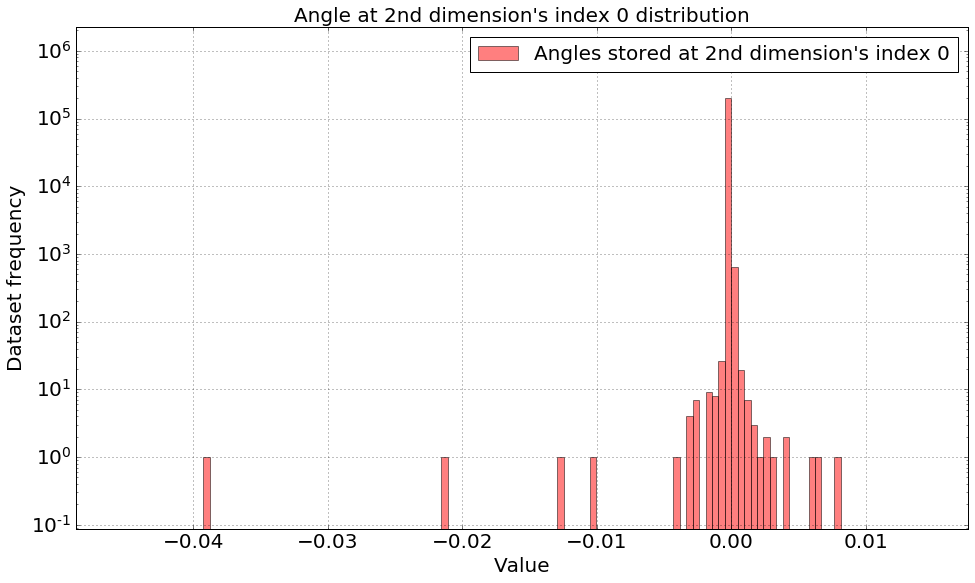

In [198]:
num_bins = 100

# Initialize the plot and corresponding parameters
fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
ax.tick_params(axis="both", labelsize=20)

# Setup the bins beforehand
bins = np.linspace(np.amin(angles_np[:,0]),
                   np.amax(angles_np[:,0]),
                   num_bins)

# Plot the histograms overlaid
plt.hist(angles_np[:,0], bins, density=False,
         label="Angles stored at 2nd dimension's index 0", color="red",
         alpha=0.5, stacked=True)

# Setup the axes
ax.set_xlabel("Value", fontsize=20)
ax.set_ylabel("Dataset frequency", fontsize=20)

plt.margins(0.2)
plt.grid(True)

plt.yscale("log")
plt.legend(loc="upper right", prop={"size":20})
plt.title(r"Angle at 2nd dimension's index 0 distribution",fontsize=20)

plt.show()

### Plot the histogram for the angles stored at 2nd dimension's index 1

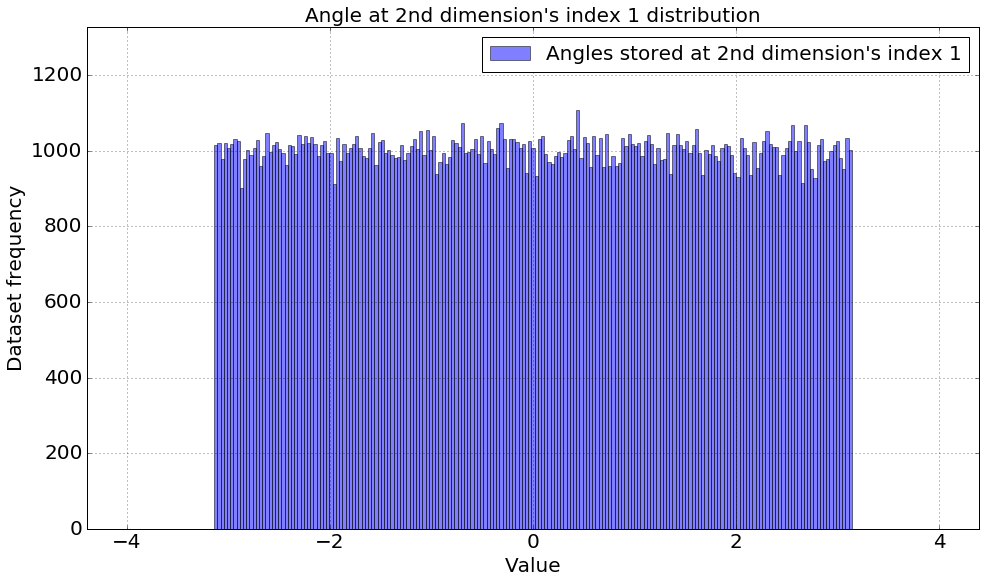

In [199]:
num_bins = 200

# Initialize the plot and corresponding parameters
fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
ax.tick_params(axis="both", labelsize=20)

# Setup the bins beforehand
bins = np.linspace(np.amin(angles_np[:,1]),
                   np.amax(angles_np[:,1]),
                   num_bins)

# Plot the histograms overlaid
plt.hist(angles_np[:,1], bins, density=False,
         label="Angles stored at 2nd dimension's index 1", color="blue",
         alpha=0.5, stacked=True)

# Setup the axes
ax.set_xlabel("Value", fontsize=20)
ax.set_ylabel("Dataset frequency", fontsize=20)

plt.margins(0.2)
plt.grid(True)

plt.legend(loc="upper right", prop={"size":20})
plt.title(r"Angle at 2nd dimension's index 1 distribution",fontsize=20)

plt.show()

### Print the minimum and maximum values in the dimension 2 index 1

In [ ]:
print("Minimum azimuthal angle : ", np.amin(angles_np[:,1]))
print("Maximum azimuthal angle : ", np.amax(angles_np[:,1]))

So above we have an "almost" uniform distribution of the azimuthal angles values from $-\pi$ and $\pi$

## Fit the k-nearest neighbour method along the energy and angle feature space

In [3]:
test_iter_list = list(test_iter)

In [167]:
labels = []
energies = []
indices = []
angles = []

for data in test_iter:
    labels.append(data[1])
    energies.append(data[2])
    angles.append(data[3])
    indices.append(data[4])

In [168]:
num_batches = len(labels)
num_samples_per_batch = labels[0].size(0)
num_samples = (num_batches-1)*num_samples_per_batch

labels_np, energies_np, indices_np, angles_np = np.ndarray((num_samples)), np.ndarray((num_samples)), np.ndarray((num_samples)), np.ndarray((num_samples))

i = 0
j = 0

while i < num_batches-1:
    labels_np[j:j+num_samples_per_batch]   = labels[i].numpy()
    energies_np[j:j+num_samples_per_batch] = energies[i].numpy().reshape(-1)
    indices_np[j:j+num_samples_per_batch]  = indices[i].numpy()
    angles_np[j:j+num_samples_per_batch]   = angles[i].numpy()[:,1]

    i = i + 1
    j = j + num_samples_per_batch

In [138]:
print(energies_np.shape)

(199680,)


In [139]:
print(labels_np[:100])

[1. 2. 2. 2. 1. 0. 1. 1. 0. 0. 0. 2. 0. 0. 2. 1. 0. 2. 1. 1. 0. 0. 2. 2.
 1. 2. 2. 0. 2. 0. 2. 0. 1. 1. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 2. 1. 1. 1.
 2. 2. 1. 0. 0. 1. 1. 2. 1. 0. 1. 0. 1. 2. 2. 1. 1. 2. 2. 0. 1. 2. 2. 2.
 1. 1. 1. 0. 2. 2. 1. 1. 1. 1. 1. 0. 2. 1. 0. 0. 2. 0. 2. 0. 0. 2. 0. 0.
 0. 2. 2. 1.]


In [169]:
energies_np = energies_np[labels_np == 2.]
indices_np = indices_np[labels_np == 2.]
angles_np = angles_np[labels_np == 2.]

In [162]:
print(energies_np.shape)

(66515,)


In [163]:
print(num_batches, num_samples_per_batch, num_samples)

196 1024 199680


In [164]:
print(energies_np.shape)

(66515,)


In [165]:
print(angles_np[:100])
print(angles_np[angles_np.shape[0]-100:])

[ 2.34092140e+00 -5.65400541e-01 -3.49891454e-01 -1.07789135e+00
 -3.00509501e+00 -2.20421147e+00  6.11974776e-01 -2.71053410e+00
 -1.86614215e+00  6.56698406e-01  4.49350566e-01 -1.30593491e+00
 -4.95840141e-05  1.92793012e+00  2.57053781e+00  1.18138766e+00
  6.34874552e-02  3.12268901e+00  1.16356254e+00 -1.54544461e+00
  8.17228377e-01  8.78443420e-01  1.82304192e+00 -7.64223158e-01
 -4.94376779e-01 -2.69781804e+00 -1.95580214e-01  1.50505340e+00
 -4.77036685e-01 -2.28359008e+00  7.80376077e-01 -2.17890215e+00
  1.71268845e+00  8.61553490e-01  1.17989147e+00  1.56879294e+00
  2.99185485e-01 -6.59297407e-01  1.89619887e+00  2.96779585e+00
  3.61676902e-01 -9.56014335e-01 -1.83043969e+00  2.96801972e+00
 -1.76357961e+00  2.04114944e-01 -2.62470603e-01  2.57939905e-01
  5.11729009e-02  1.87263906e+00  1.98164904e+00  1.38201678e+00
  8.86037871e-02  1.18964064e+00 -1.84062254e+00  1.57555544e+00
 -1.46918178e+00 -2.46086359e+00 -2.54433155e+00  1.45165718e+00
  8.67559493e-01 -1.14265

In [88]:
print(len(labels))

196


In [89]:
print(labels[0].shape[0])

1024


In [95]:
i = 0
energies_np = np.ndarray((len(energies), energies[0].size(0)))
while i < len(energies)-1:
    energies_np[i] = energies[i].numpy().reshape(-1)
    i = i + 1

In [96]:
print(labels_np.shape)

(196, 1024)


In [97]:
print(energies_np.shape)

(196, 1024)


In [15]:
labels_tensor = torch.zeros((len(labels)-1)*labels[0].size(0))
energies_tensor = torch.zeros((len(energies)-1)*energies[0].size(0), energies[0].size(1))
indices_tensor = torch.zeros((len(indices)-1)*indices[0].size(0))
angles_tensor = torch.zeros((len(angles)-1)*angles[0].size(0), 1)

In [16]:
i = 0
j = 0
while j < len(energies)-1:
    labels_tensor[i:i+labels[j].size(0)] = labels[j][:]
    energies_tensor[i:i+energies[j].size(0),0] = energies[j][:,0]
    indices_tensor[i:i+indices[j].size(0)] = indices[j][:]
    angles_tensor[i:i+angles[j].size(0),0] = angles[j][:,1]
    i = i + energies[j].size(0)
    j = j + 1
        
labels_np = labels_tensor.numpy()
energies_np = energies_tensor.numpy()
indices_np = indices_tensor.numpy()
angles_np = angles_tensor.numpy()

In [17]:
labels_np = labels_np.reshape(-1)
energies_np = energies_np.reshape(-1)
indices_np = indices_np.reshape(-1)
angles_np = angles_np.reshape(-1)

In [18]:
azimuthal_angles_np = angles_np

In [19]:
print(labels_np.shape, energies_np.shape, indices_np.shape, azimuthal_angles_np.shape)

(199680,) (199680,) (199680,) (199680,)


In [20]:
print(azimuthal_angles_np[:100])

[-0.8186611   2.4736035   0.6566093  -2.9000955  -0.6399245  -0.50786614
  1.8479953   2.0980868   2.5519338  -2.6334136   3.0714672   2.2405045
 -1.7996128  -1.8090463   0.89677596 -3.015656   -0.09850531  1.2805827
 -0.98894286  0.9277983  -0.8566152  -0.2658603  -2.163217   -1.2737114
 -1.880715   -1.0963134   0.74761343  1.1236262   2.7767637  -1.7768252
 -1.5004244  -1.4716247  -2.783503    1.3177626   1.1050773   2.789325
 -1.7148885   0.6255555   1.9129375  -0.2680856   2.0116422  -0.70589435
 -1.793205   -0.13663802  1.0279636   2.127064   -0.6218894   2.1853113
  1.2881458   3.112802    2.2780612  -0.52712065 -2.6901324   2.5073383
 -0.06537902  2.1172636   2.0822673  -2.0228162   0.06224596 -0.06601605
 -1.6116139  -0.33086085 -0.81105494  1.9580803   1.3180019  -2.6569738
  1.9091909   1.943594   -2.638153    1.4727502   2.6420605  -0.5993635
  3.1062841   2.7875483   1.7822045   0.5963866  -2.328213   -1.6265604
 -3.1209507   0.23305276 -1.6659331  -0.9146796  -1.1143991  -

In [39]:
print(energies_np[:100])

[260.8927  348.94952 152.58788 517.5771  361.3514  692.26733 226.66963
 146.55283 199.13101 854.69586 671.87714 779.92346 781.9626  242.14021
 213.17854 175.2351  625.45325 189.36414 791.0067  415.92242 260.38998
 684.76996 591.88605 384.94412 539.9663  895.636   575.6217  439.32056
 697.82526 175.16943 560.9299  833.3807  176.40004 740.0601  633.484
 299.6627  922.6328  206.33797 278.47568 913.24066 979.39667 570.21674
 264.7687  707.7313  730.44135 721.5097  297.35382 260.7285  761.84064
 402.70102 764.6844  470.793   914.6547  814.3343  453.34875 968.2916
 276.88644 701.5172  399.5097  923.107   224.48422 605.232   326.61438
 646.5187  280.9563  135.2815  348.2701  235.80125 893.0371  411.6893
 930.2549  302.61447 582.208   203.1324  282.83856 735.0611  809.2506
 465.4021  171.72316 479.3893  162.00414 567.0824  292.89212 205.44635
 326.314   983.687   455.50247 893.8819  265.10156 277.1061  398.75085
 970.2464  401.40018 853.29956 223.61351 530.2832  866.64777 694.21124
 128.37477 

The numpy arrays for learning the fit is now ready. Fit the k-nearest neighbour method.

In [170]:
nn_features = np.array([angles_np, energies_np])
print(nn_features.shape)

(2, 66543)


In [171]:
nn_features = nn_features.T
print(nn_features.shape)

(66543, 2)


In [172]:
print(nn_features[:10])

[[-1.64820623e+00  7.81190308e+02]
 [-2.34549093e+00  1.03150757e+03]
 [-6.45967543e-01  8.58980408e+02]
 [-9.36051250e-01  5.92136902e+02]
 [ 9.67041016e-01  4.12401031e+02]
 [ 2.81531096e+00  5.37584900e+02]
 [ 1.37911212e+00  3.90913788e+02]
 [-1.22031951e+00  1.11825830e+03]
 [-1.03320932e+00  1.21473059e+03]
 [-2.63327694e+00  7.92480957e+02]]


In [173]:
from sklearn import neighbors
nbrs = neighbors.NearestNeighbors(n_neighbors=1000, algorithm='ball_tree', metric='euclidean').fit(nn_features)

In [149]:
print(nbrs)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=1000, p=2,
                 radius=1.0)


Now that the `neighbors.NearestNeighbors()` method is now fit. Can use to find the nearest neighbors of some reference point.

In [174]:
reference_point_1 = np.array([0, 200]).reshape(1, -1)
distances, neighbors_1 = nbrs.kneighbors(reference_point_1, return_distance=True)

In [181]:
print(neighbors_1)

[57845 64849 51832 42560 26629 50271 15590 25880  8820 65504  8463 52391
  3433  1560 48903 40328 16371 26718  3387 51404 30263 52814 66542 45883
 55464 36679 52430 22044 33977 40386 32690 66341 48897  9910 48053 16880
 24685 19617 60722 12856 30157 53249 65870 17085 20769 16635  1916 60132
 12064 23096 58066 47469 35309 16985 55965 49555  3246 43675 26072 16478
  3682 61142 14828  7375  4067 43108  5693 10174 58200 28169 44071 14952
 39369 47164 57599  1706 62988 10949 30295  7351 14937 55468  4491 22311
 14086 30394  9628 24767 49337  6832 29237 64693 39795 46583 20847 45726
 22635 61095 66273 25623 23018 37684  3284 33135 54450  5539 55803 40007
 35941 28838 37399  6013 37916 30660 35125 16665  8365 13964  2447 15761
 12796  7170 12873  7205 21502 34527 46969 28901 19666 44751 19443  9334
 13138 36004 20985 48787 43416 23301 50952 12617 20469 62636 26772 30863
  2085  2267 17715 61606  1892 47146 65277 39054 38610 10400 64406 56579
 37852 40089  3500  7841 33092 12633 20031 40634 16

In [182]:
print(distances)

[[164.37512107 164.37512107 164.37694039 164.38066973 164.3858488
  164.39209222 164.40063715 164.4008679  164.40604596 164.41652209
  164.4174398  164.43170891 164.43259543 164.44203858 164.44434602
  164.44624067 164.47616353 164.47616353 164.48742918 164.50962306
  164.51959438 164.54005418 164.5416662  164.56059075 164.56437664
  164.57596268 164.58235918 164.58879504 164.61067646 164.61399814
  164.62131091 164.62347548 164.65487552 164.66134955 164.66236033
  164.69278966 164.69880891 164.70094308 164.73514747 164.73570661
  164.74464529 164.77602476 164.78029133 164.78184416 164.81975416
  164.82808381 164.84000427 164.85043907 164.85201108 164.85502066
  164.87208538 164.87775771 164.92666123 164.92775581 164.94084602
  164.94124084 164.99121133 164.99581477 164.99807633 164.99833114
  165.00802912 165.01370881 165.01963486 165.03624479 165.0380649
  165.04628713 165.05048158 165.07453852 165.09506691 165.09925467
  165.10036742 165.12894862 165.12927322 165.1315024  165.139076

Using the indices returned by the nearest neighbor method, plot the event data of a single particle type.

In [175]:
neighbors_angles = nn_features[neighbors_1]

In [153]:
print(neighbors_angles)

[[[-3.57431285e-02  1.99885574e+02]
  [ 1.61906853e-01  2.00094620e+02]
  [ 1.71558663e-01  2.00122940e+02]
  [-1.78947613e-01  1.99717453e+02]
  [ 3.38198662e-01  1.99784775e+02]
  [-3.18635464e-01  1.99711014e+02]
  [ 3.54303986e-01  1.99700928e+02]
  [-1.40504420e-01  1.99552490e+02]
  [ 5.15469849e-01  2.00186508e+02]
  [ 3.21943194e-01  1.99465164e+02]
  [ 5.00029437e-02  1.99358185e+02]
  [ 5.62709391e-01  2.00395996e+02]
  [ 2.20741943e-01  1.99346497e+02]
  [ 1.05363734e-01  2.00691360e+02]
  [ 4.90639985e-01  2.00519104e+02]
  [-3.16941947e-01  1.99332489e+02]
  [-7.44198978e-01  2.00050522e+02]
  [-4.17225629e-01  1.99344131e+02]
  [-7.65686393e-01  1.99843079e+02]
  [-1.53760478e-01  1.99222900e+02]
  [ 6.91397667e-01  2.00443359e+02]
  [ 5.02421618e-01  2.00655106e+02]
  [ 5.29185414e-01  2.00643463e+02]
  [-4.93286937e-01  1.99327286e+02]
  [-2.79580712e-01  1.99208847e+02]
  [-1.41433969e-01  2.00855896e+02]
  [-8.01743925e-01  1.99630066e+02]
  [-5.57811558e-01  2.006887

### Display the nearest 10 neighbours to the virtual samples

In [176]:
neighbors_1 = neighbors_1.reshape(-1)
neighbors_1_10 = neighbors_1[:10]
neighbors_1_10_indices = indices_np[neighbors_1_10]

In [155]:
print(indices_np[indices_np.shape[0]-1000:])

[1643201.  686452.  735652. 1793428. 1993542. 1479349. 2614366. 2992290.
 1020492.  788846.  979491. 1762786. 1380179.  150726. 2056853.  664218.
 2223468. 1366305.  268545.  909158. 1372461.  601934. 1427738. 2335879.
 1230051.   54926.  761832.  289663.  811964. 1383142. 1093824. 2377379.
 1366825.  499473.  655370. 2725224.  679275. 1658295. 1599372.  331019.
 1317093.  111646. 1382201. 2189757. 2339394.  617818. 1519537. 1885991.
  329573. 2978539.  816261. 1302210. 1064105.  668080.  292724. 2838782.
 2245434. 2737426.  245610. 2740674. 1307420. 1189116. 1328250. 1086417.
 2380475. 1349175. 2530883. 2897941. 2031758.  683760. 1106353. 1567457.
  194568.  777369. 2549051. 1146824. 2574077. 1659362. 1932544. 2350250.
 1396441.  303090.  204635.  458543. 2602241.  510875. 2296608. 1307760.
 2415120.   61309. 2669833. 2060094.  902943.  708553. 2726976.  954517.
  147456. 2844168. 2431420.  365626. 2113764.  948403. 1070845.  495922.
 1362109. 2539646. 2545905. 2764877. 2071878. 26052

In [156]:
print(neighbors_1_10_indices)
print(neighbors_1_10)

[2026281.  855369. 1881117. 2102286.  653444. 1999565.  599527. 2965486.
 2157274.  437017.]
[43152 30507 59887 53938 54069 23794 32863 58391 33143 56003]


In [177]:
events = []
labels = []
energies = []
az_angles = []

for data in test_iter:
    indices = data[4]
    for i, index in enumerate(indices):
        if index.numpy().item() in neighbors_1_10_indices:
            print(index, data[3][i])
            events.append(data[0][i])
            labels.append(data[1][i])
            energies.append(data[2][i])
            az_angles.append(data[3][i][1])

tensor(3568136) tensor([-3.6732e-06,  1.3329e+00])
tensor(5593600) tensor([-3.6732e-06, -2.5637e+00])
tensor(3309281) tensor([-3.6732e-06, -1.0786e+00])
tensor(3309281) tensor([-3.6732e-06, -1.0786e+00])
tensor(3580855) tensor([-3.6732e-06,  1.1044e+00])
tensor(5882223) tensor([-3.6732e-06, -2.6356e+00])
tensor(3003828) tensor([-3.6732e-06,  2.2768e+00])
tensor(3001179) tensor([-3.6732e-06,  1.5147e+00])
tensor(3166441) tensor([-3.6732e-06, -1.5041e+00])
tensor(4640801) tensor([-3.6732e-06, -1.9052e+00])


In [178]:
print(len(events))

10


In [179]:
print(az_angles)

[tensor(1.3329), tensor(-2.5637), tensor(-1.0786), tensor(-1.0786), tensor(1.1044), tensor(-2.6356), tensor(2.2768), tensor(1.5147), tensor(-1.5041), tensor(-1.9052)]


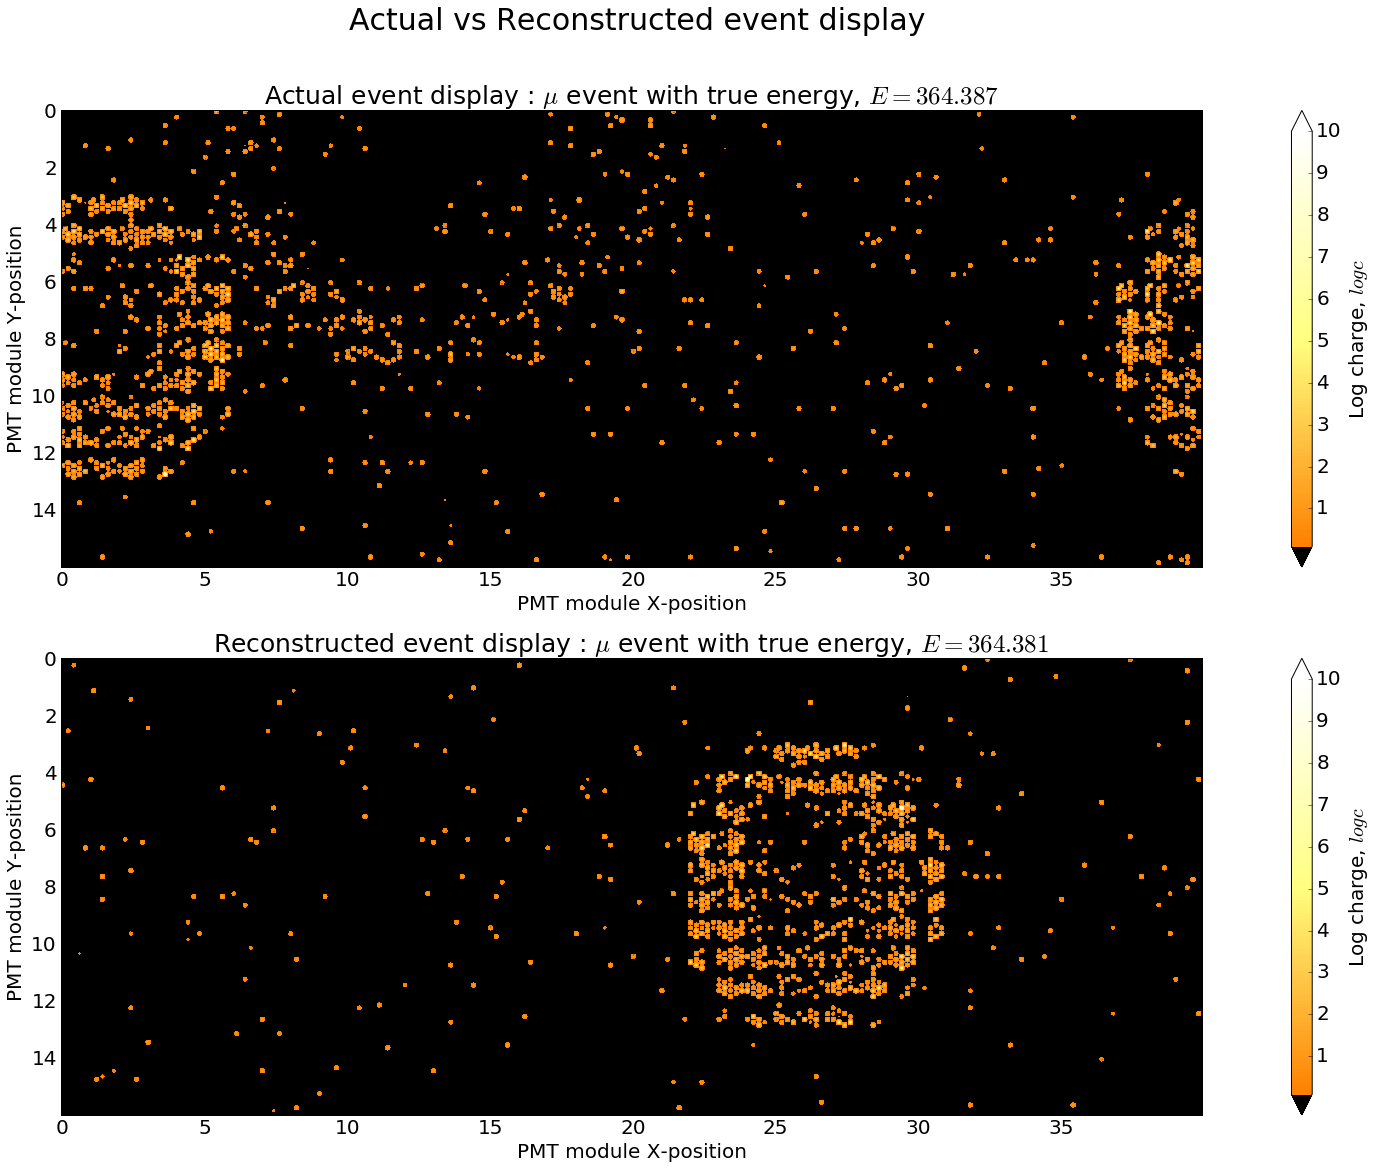

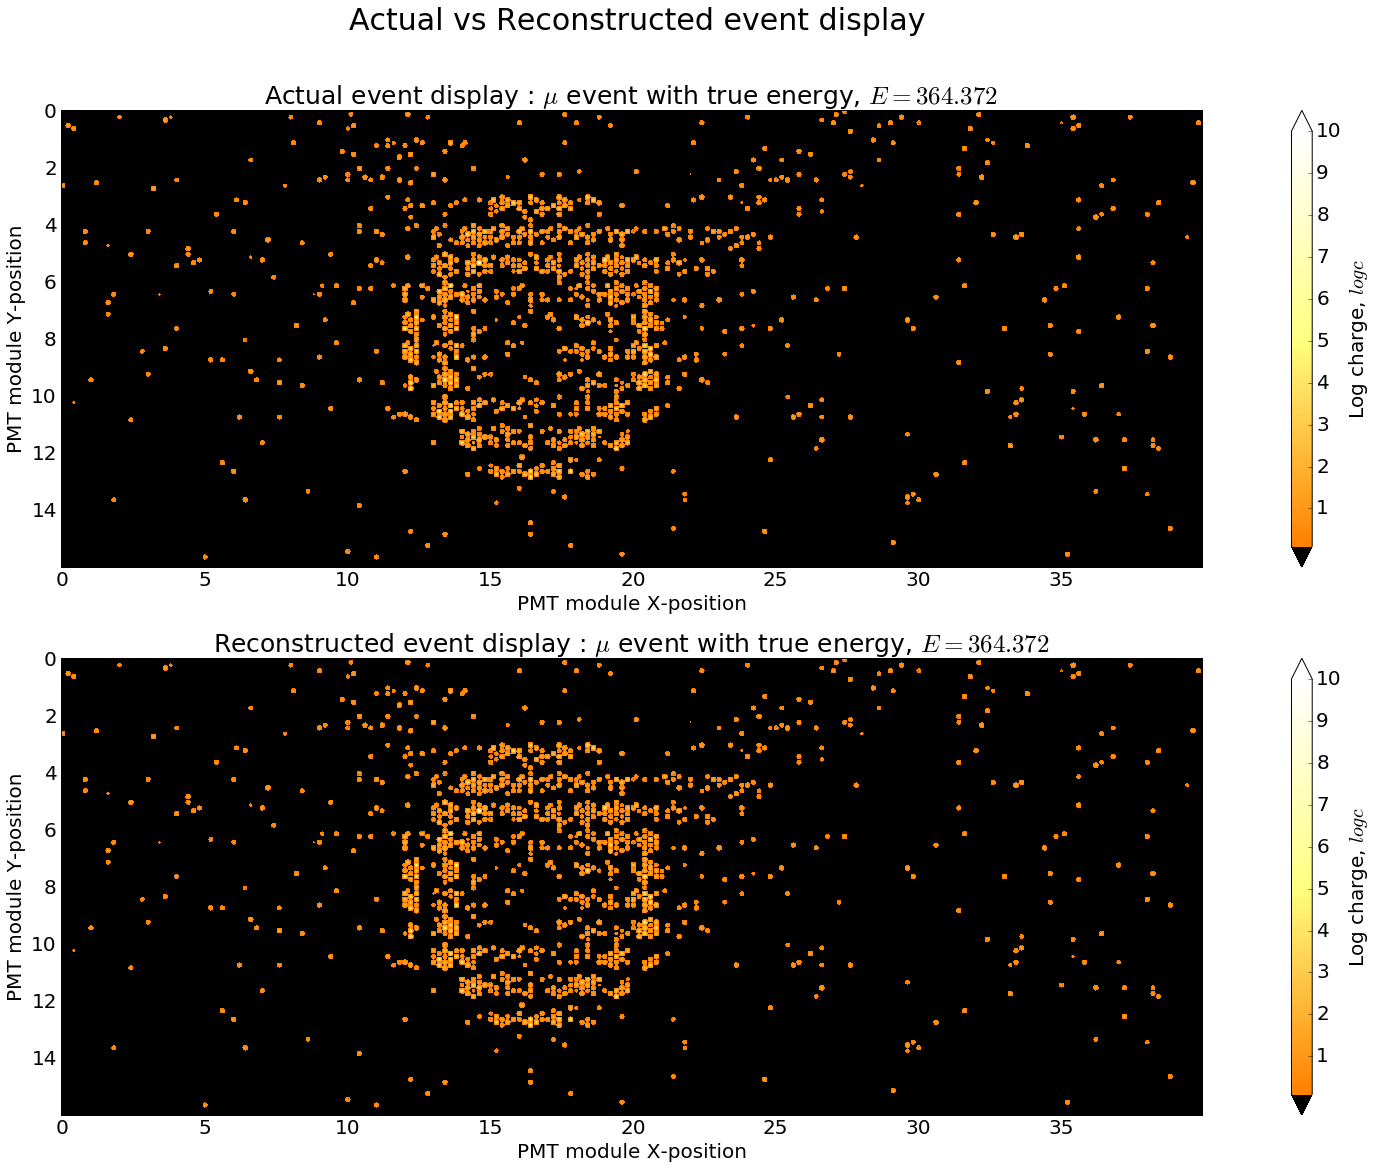

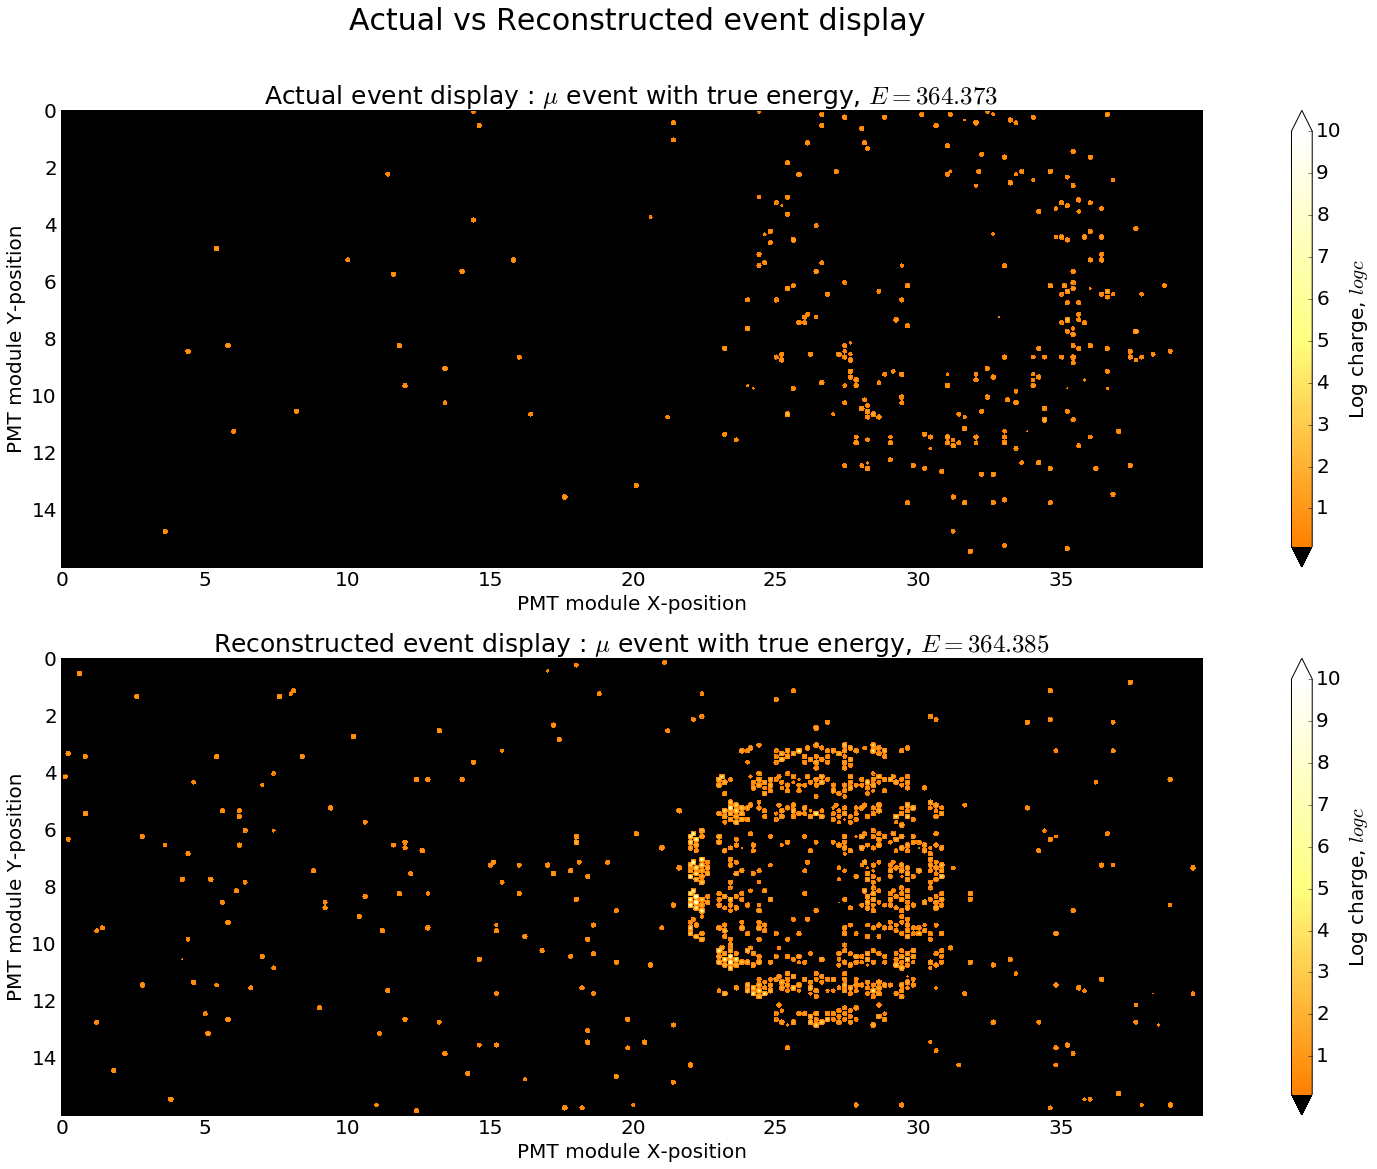

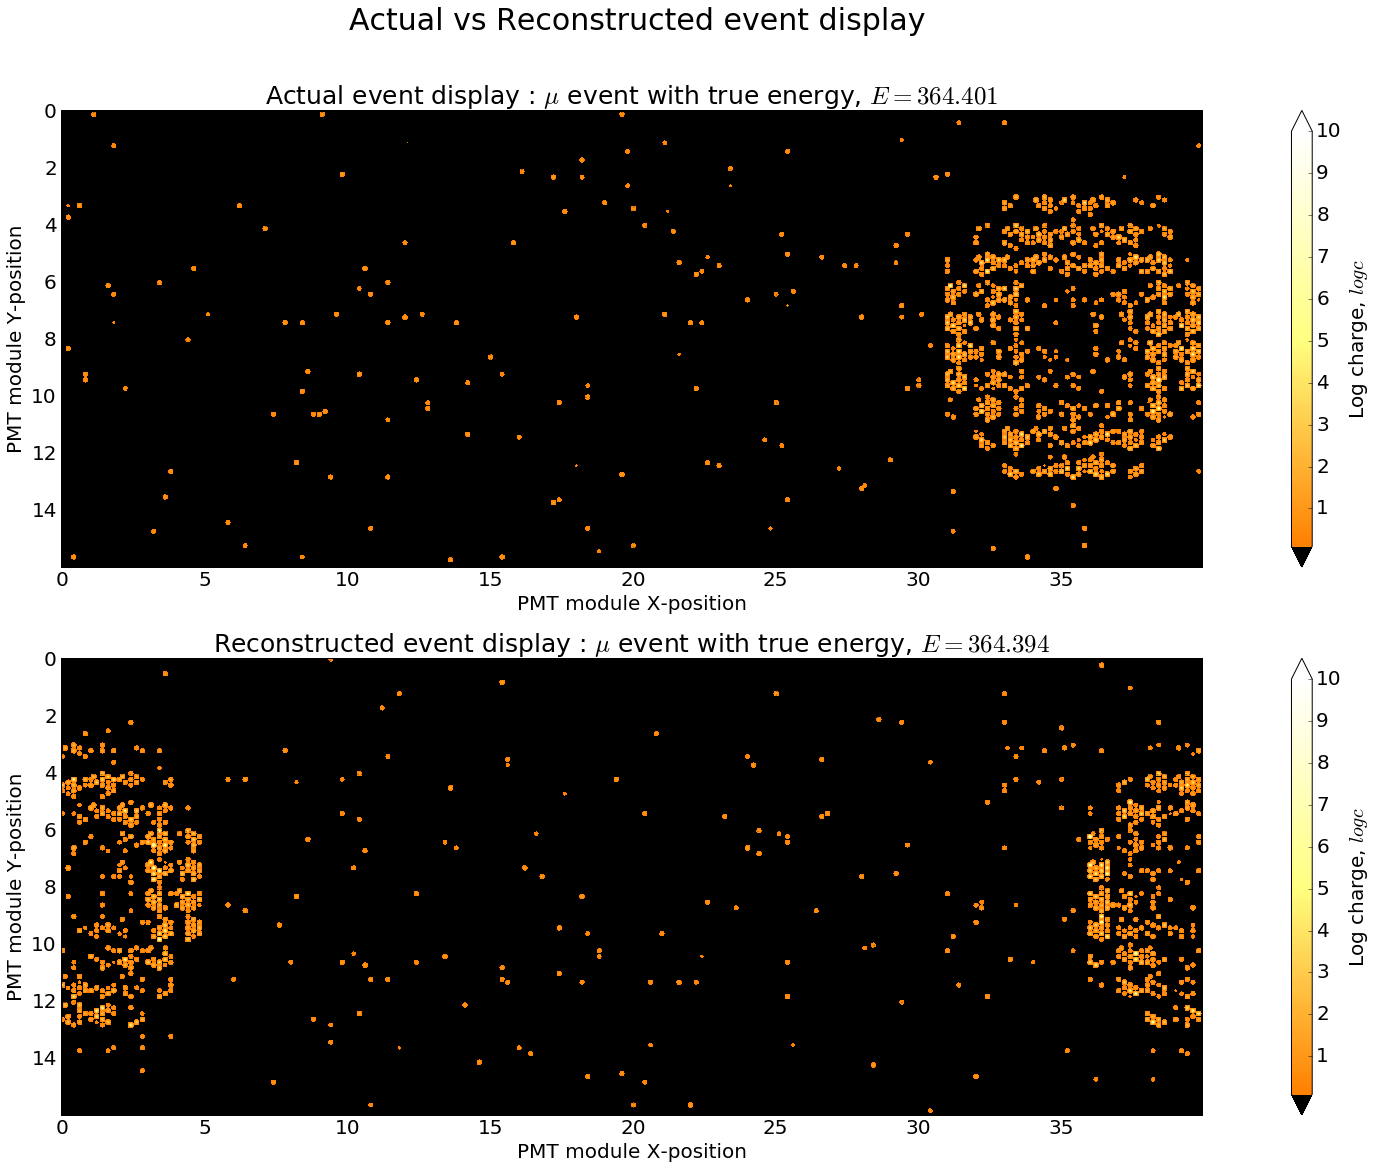

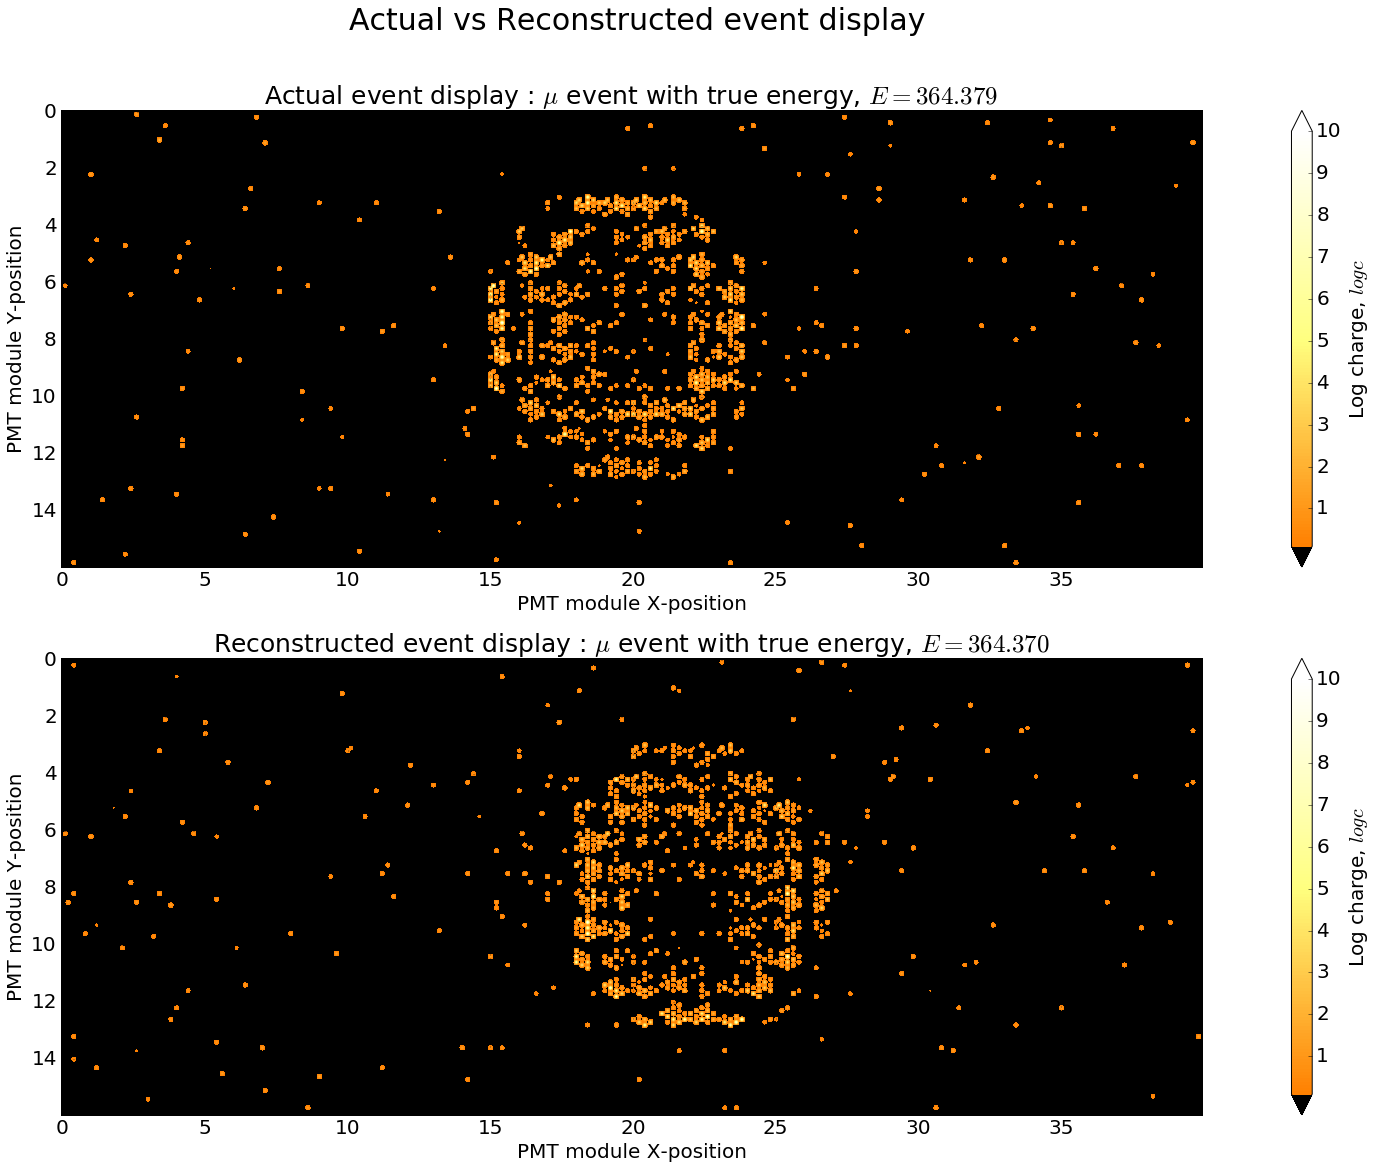

In [180]:
i = 0
label_dict = {0:"gamma", 1:"e", 2:"mu"}
while i < len(events)-1:
    plot_utils.plot_actual_vs_recon(events[i][:,:,:19].numpy(), events[i+1][:,:,:19].numpy(), 
                                    label_dict[labels[i].item()], energies[i].item(),
                                    label_dict[labels[i+1].item()], energies[i+1].item(),
                                    show_plot=True)
    i = i + 2

### Extract the samples around the second reference point

In [68]:
reference_point_2 = np.array([0, 800]).reshape(1, -1)
distances_2, neighbors_2 = nbrs.kneighbors(reference_point_2, return_distance=True)

In [69]:
neighbors_2 = neighbors_2.reshape(-1)
neighbors_2_10 = neighbors_2[:10]
neighbors_2_10_indices = indices_np[neighbors_2_10]

In [70]:
events = []
labels = []
energies = []
az_angles = []

for data in test_iter:
    indices = data[4]
    for i, index in enumerate(indices):
        if index.numpy().item() in neighbors_2_10_indices:
            print(index, data[3][i])
            events.append(data[0][i])
            labels.append(data[1][i])
            energies.append(data[2][i])
            az_angles.append(data[3][i][1])

tensor(18318) tensor([-3.6732e-06, -1.0087e-01])
tensor(24494) tensor([-3.6732e-06, -2.5097e-03])
tensor(28130) tensor([-3.6732e-06,  6.8137e-02])
tensor(40366) tensor([-3.6732e-06, -2.3245e-01])
tensor(74047) tensor([-3.6732e-06,  1.9466e-01])
tensor(104570) tensor([-3.6732e-06,  1.3373e-02])
tensor(105487) tensor([-3.6732e-06,  3.9793e-02])
tensor(144460) tensor([-3.6732e-06,  3.4266e-01])
tensor(170848) tensor([-3.6732e-06,  2.2593e-01])
tensor(193201) tensor([-3.6732e-06,  1.5077e-01])


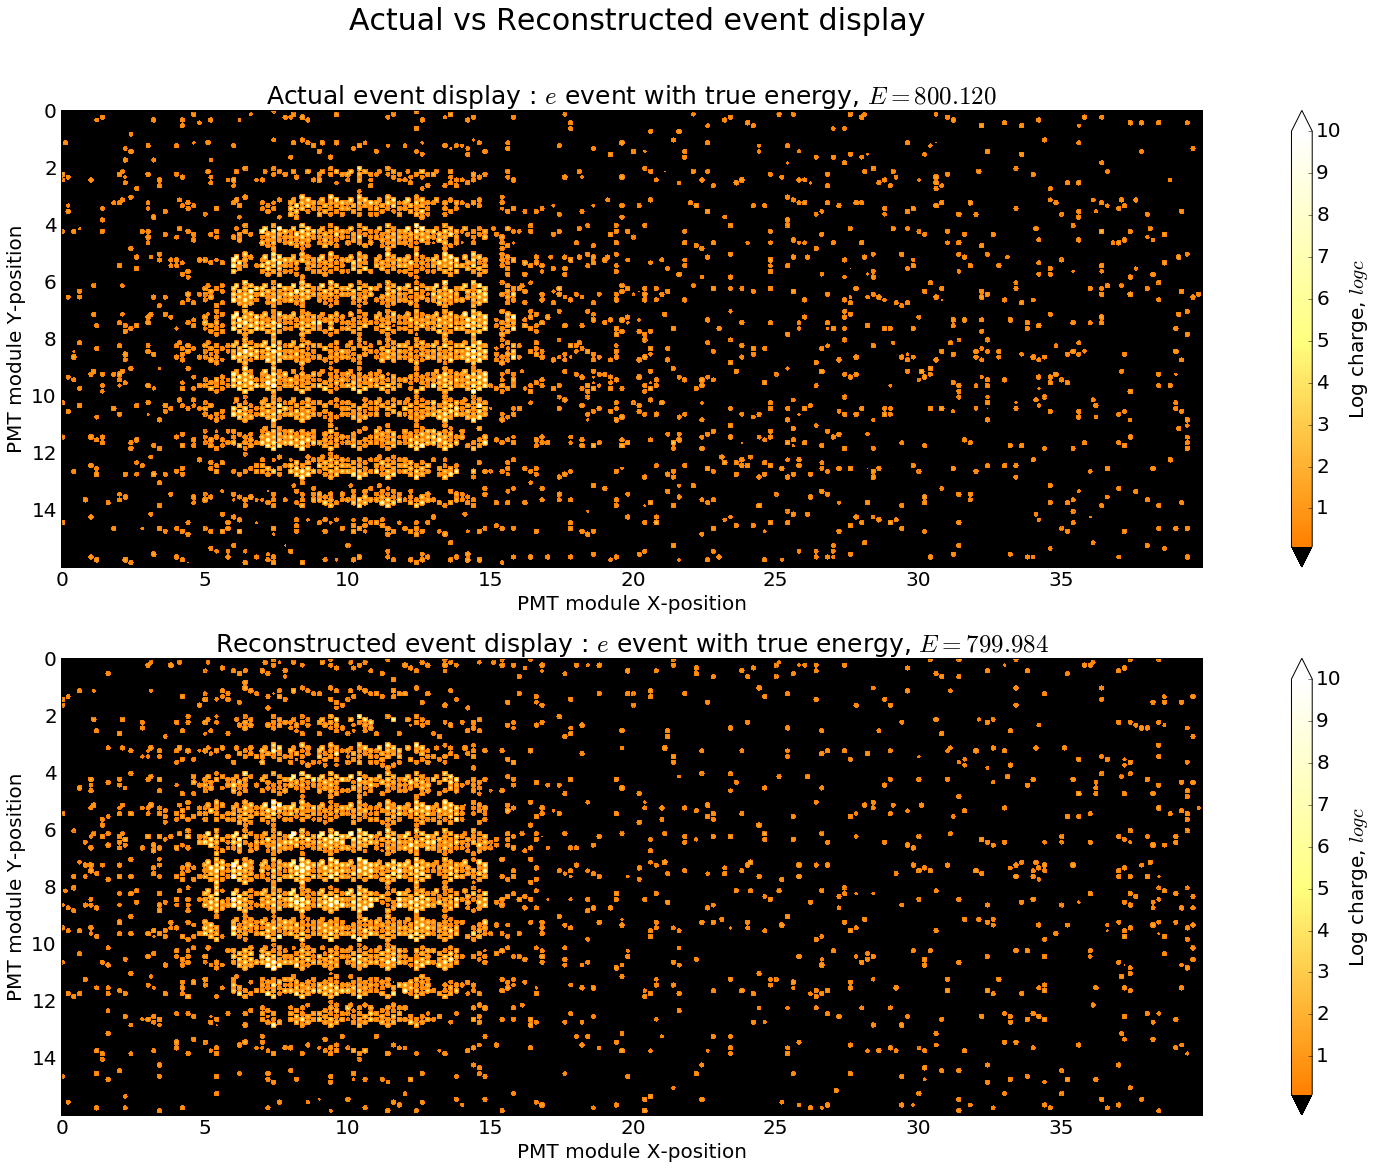

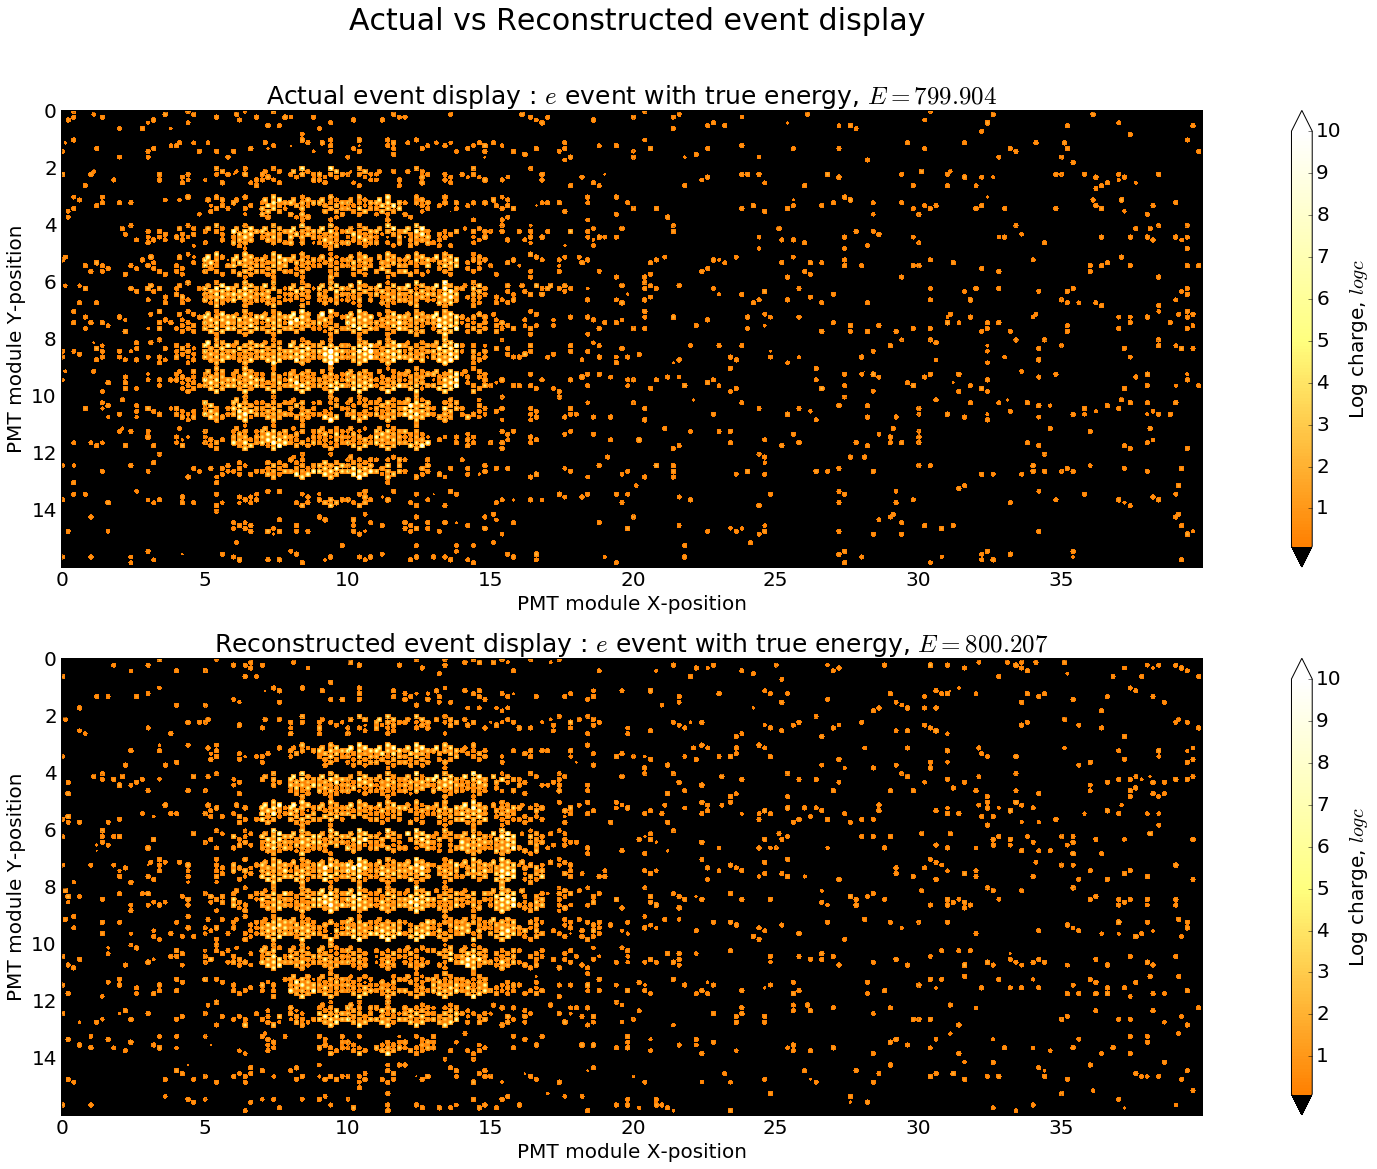

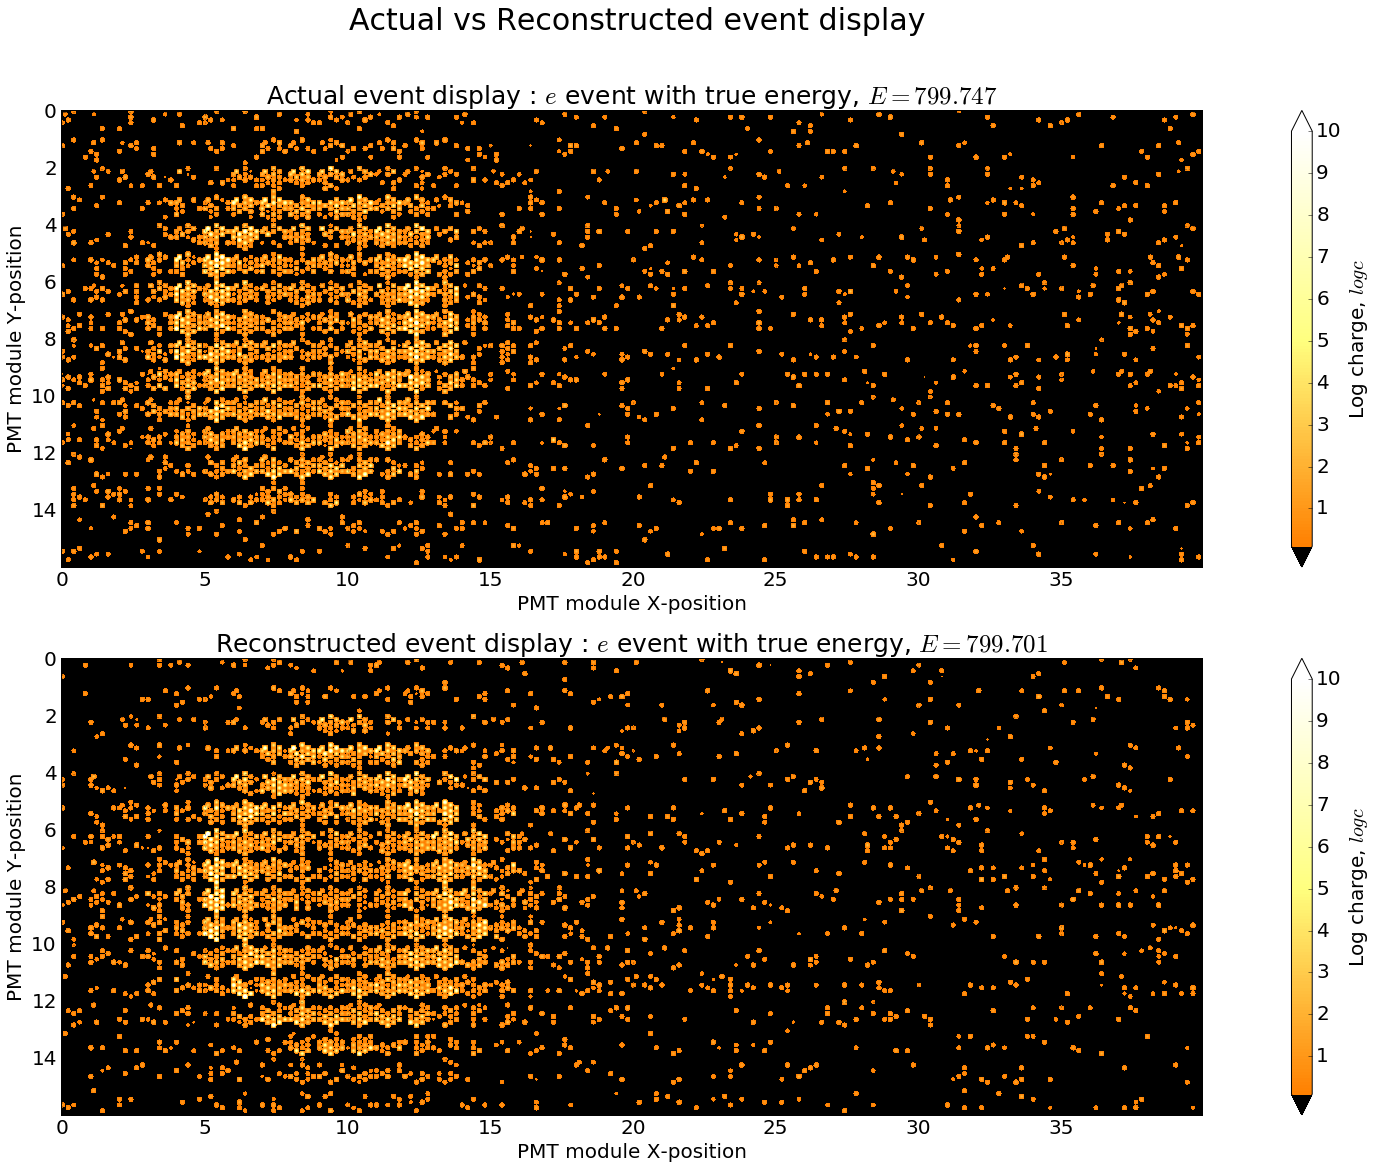

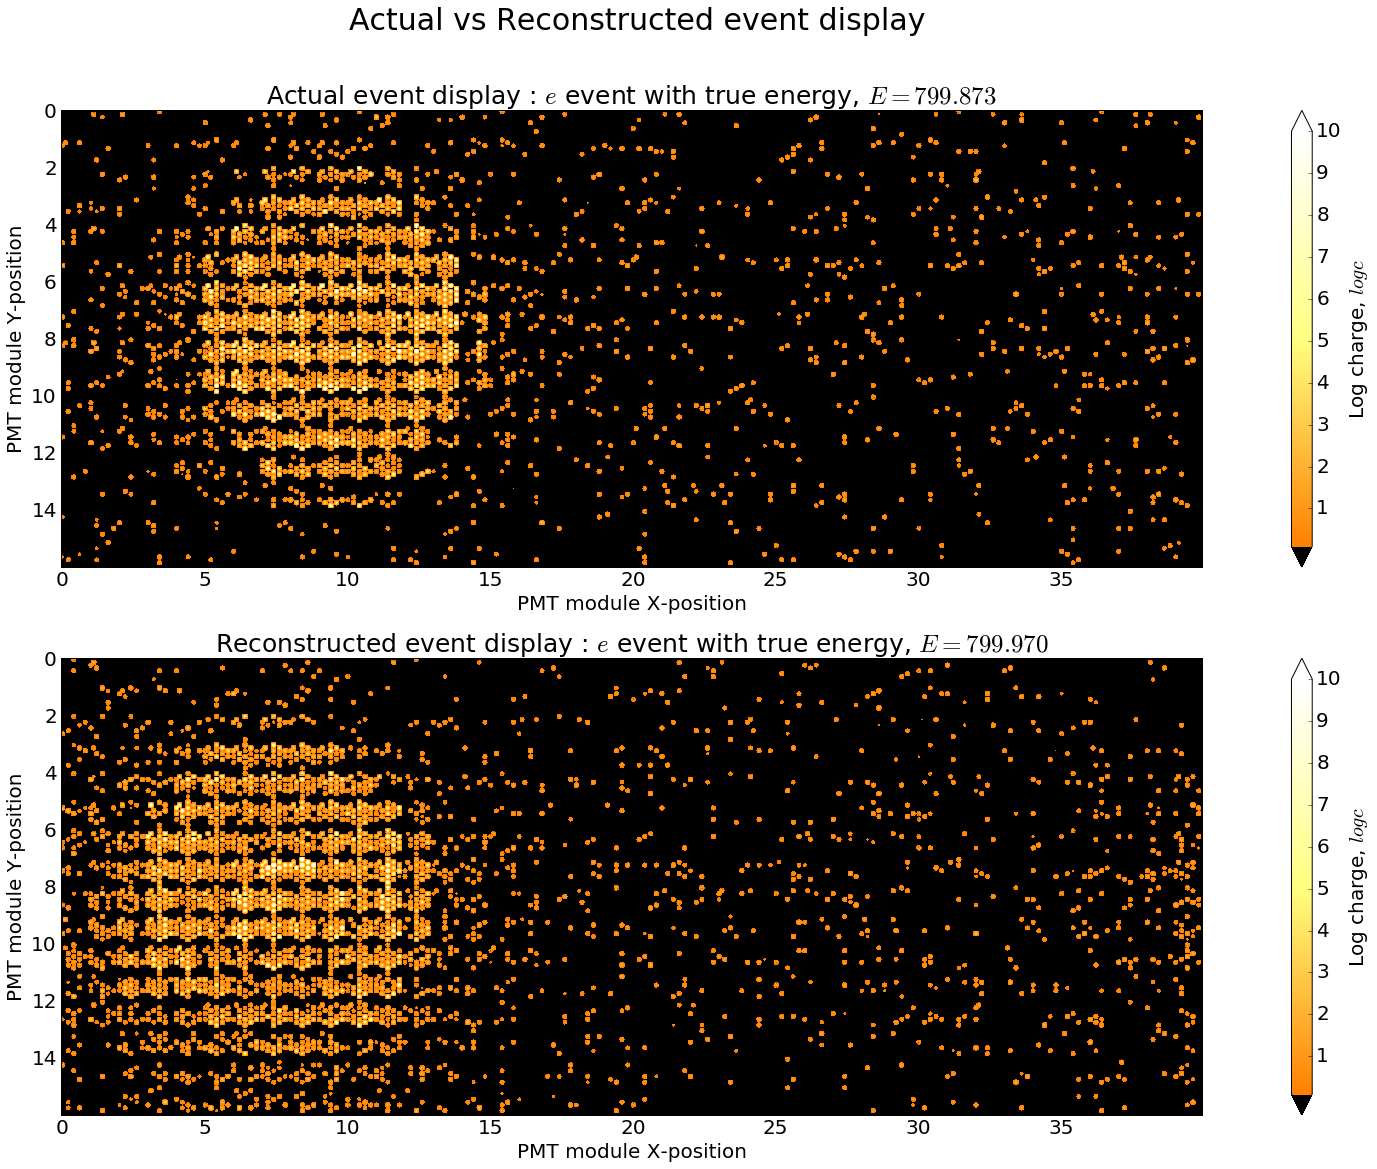

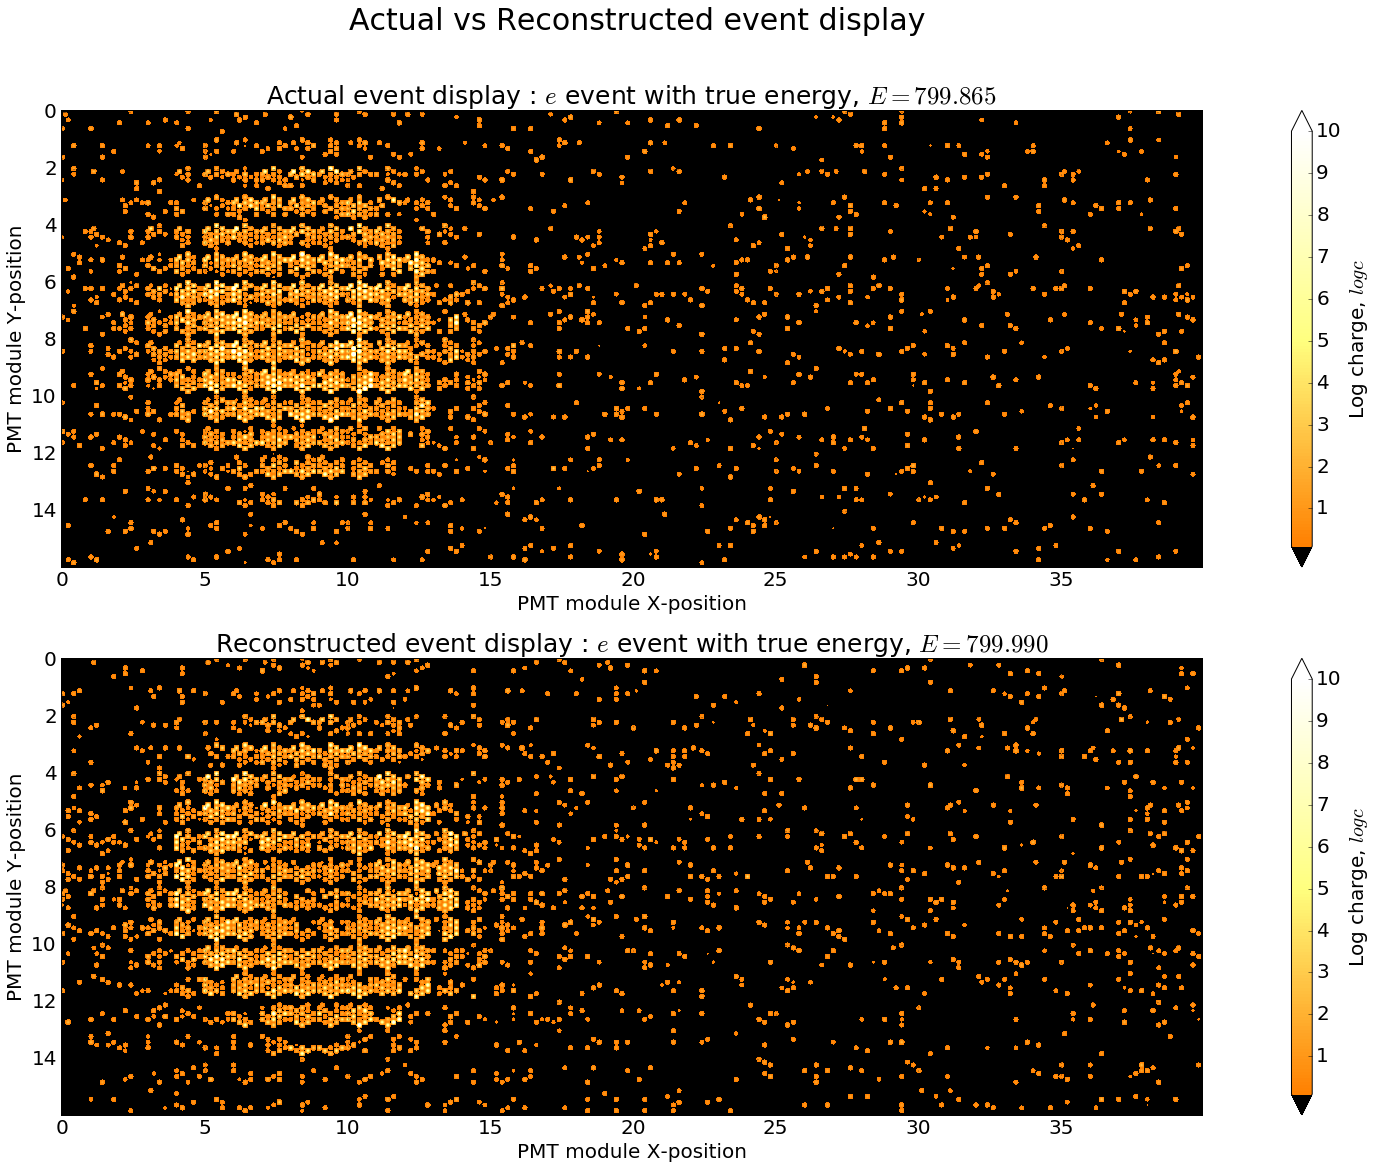

In [71]:
i = 0
label_dict = {0:"gamma", 1:"e", 2:"mu"}
while i < len(events)-1:
    plot_utils.plot_actual_vs_recon(events[i][:,:,:19].numpy(), events[i+1][:,:,:19].numpy(), 
                                    label_dict[labels[i].item()], energies[i].item(),
                                    label_dict[labels[i+1].item()], energies[i+1].item(),
                                    show_plot=True)
    i = i + 2